## The Bias Variance Trade-off

### Packages Versions

In [1]:
import sys
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

print('The Python version is {}.\n'.format(sys.version))
print('The Numpy version is {}.\n'.format(np.__version__))
print('The Pandas version is {}.\n'.format(pd.__version__))
print('The Matplotlib version is {}.\n'.format(mpl.__version__))
print('The Scikit-Learn version is {}.\n'.format(sklearn.__version__))

The Python version is 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0].

The Numpy version is 1.19.1.

The Pandas version is 1.1.0.

The Matplotlib version is 3.3.3.

The Scikit-Learn version is 0.24.0.



### Logistic Regression Coefficients and Intercept Estimation

The **parameters** of a Logistic Regression model reflect the best approximation to the data. The process of finding this best approximation is called **estimation**. To estimate the best parameters the model uses a concept of **cost function**, which is a way of telling how far the model prediction are from perfectly describing the data.

In classification models there are different cost functions, being their particularities dependent on the model itself. Specifically in fitting logistic regression models, a typical cost function is the **log-loss** function (also called **cross entropy loss**):

>$ \text{log loss} = \frac{1}{n}\sum_{i=1}^{n} - (y_{i}\log(p_{i}) + (1 - y_{i})\log(1 - p_{i}))$

Where $n$ is the training samples number, $y_{i}$ is the ture label (0 or 1) of the *i-th* sample, $p_{i}$ is the predicted probability that the *i-th* samples equals 1, and $\log$ is the natural logarithm. 

The summation notation over all the training samples and the division by $n$ serve to take the average of this cost function over all training samples.

Let's examine the log-loss function arguments. First, the natural logarithm distribution:

[0.01 0.02 0.03 0.04 0.05] ... [0.96 0.97 0.98 0.99]
[-4.60517019 -3.91202301] ... [-0.02020271 -0.01005034]


Text(0.5, 1.0, 'Natural Logarithm')

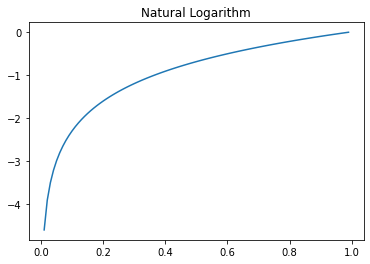

In [2]:
X_log = np.linspace(0.01, 0.99, 99)
y_log = np.log(X_log)

print(X_log[:5], '...', X_log[-4:])
print(y_log[:2], '...', y_log[-2:])

plt.plot(X_log, y_log)
plt.title('Natural Logarithm')

So, for a sample with positive class (in other words, with *y = 1*) the $(1 - y_{i})$ term equals zero and the cost function is reduced to:

> $ \text{log loss} = \frac{1}{n}\sum_{i=1}^{n} - (\log(p_{i}))$

And the cost function is the negative of the natural logarithm of the predicted probability $p_{i}$. If this sample is correctly classified and the probability to be a positive class be close to 1, the $\log(p_{i})$  term will be close to 0. If, on the other hand, this sample is incorreclty predicted with a small $p_{i}$ value, the log loss will be high and therefore increase the overall sum.

For a sample with negative class (in other words, with *y = 0*) the $y_{i}\log(p_{i})$ term equals zeor and the cost function is reduced to:

> $ \text{log loss} = \frac{1}{n}\sum_{i=1}^{n} - (\log(1 - p_{i}))$

And therefore, a similar behaviour occurs for the log loss value when the model predict a negative sample incorrectly. The $p_{i}$ will be high and the term $(1 - p_{i})$ will be low;

#### Gradient Descent

To find the best parameters, the a problem of **optimization** is set using the cost function. The **gradient descent** is the method used to make the **estimations**. It is an iterative algorithm that randomly attributes initial parameters values and iterates over the *error surface* - that is, the distribution of the **log loss** for different samples parameters - to find the least virtually cost. The gradient descent is calculated as:

> $x_{new} = x_{old} - f'(x_{old}) * \text{learning rate}$

The new parameters values is based in the current guess $x_{old}$ and the derivative of it, $f'(x_{old})$, times a learning rate, being the learning rate a *step* to a *descent* - towards the local minimum - process.